<h1>PROJETO 2 | TESTE A/B</h1>
<h3>Lucas Fontenla & Raphael Costa</h3>
_______________________________________

<ol>
<h3><li>Resumo</li></h3>
<p>Para o segundo projeto de Ciência dos Dados, fomos instruídos a avaliar duas versões diferentes de um website<p>
<p>Nós escolhemos o portfolio utilizado para o curso de Co-Design de Aplicativos, disponível nesse <a href="http://cd-teste-ab.firebaseapp.com">link.</a></p>

<h3><li>Projeto</li></h3>
<p>Foram criadas duas versões do site, ambas com a primeira página igual. As páginas da aba "Projeto" são diferentes no método de categorização dos projetos. Na versão A, o usuário precisa dar um "scroll down" na página, e há uma subcategoria que especifica mais qual o projeto. Na versão B, as categorias estão organizadas em blocos, direto na página.</p>
<p>As páginas seguintes foram modificadas muito pouco, e de maneira geral, são muito próximas.</p>
<h4>Veja páginas abaixo:</h4>

<center><h4>Versão A</h4></center>
<img src="img/projetos_vA.png" width="600">

<center><h4>Versão B</h4></center>
<img src="img/projetos_vB.png" width="600">

<h3><li>Dinâmica da Análise</li></h3>
<p>Logo na página de abertura, são sorteadas duas páginas, A e B, como mencionado acima, e ainda, outros dois projetos, "Como evacuar um arranha-céu rapidamente" de ModSim ou "Singularity - NASA" de GDE.</p>
<p>Em seguida, são medidos os tempos que o usuário leva para achar a categoria certa do projeto, o tempo para achar o projeto depois de achar a categoria e o tempo total desde o início até achar o projeto.<p>
<p><strong>Por que escolhemos dois projetos?</strong></p><p>Escolhemos dois projetos por conta da dificuldade. O Projeto de ModSim tem uma maior facilidade de ser encontrado por conta do nome da matéria e do nome da categoria. Já o de GDE, não é muito fácil de identificar a categoria correta, ou seja, estamos avaliando uma melhor versão para ambas as dificuldades</p>

<h3><li>A Análise Estatística</li></h3>
<p>A análise será feita com base no <strong>Teorema do Limite Central (TLC)</strong>, sendo a exata ferramenta discutida mais a frente, dependendo do número de amostras que obtivermos.</p>
<p>Caso as amostras sejam muito pequenas, vamos optar pela distribuição t-Student, o contrário, caso as amostras sejam maiores que n=30, vamos optar pela curva normal.</p>

<h3>PARTE 1 | Importando a base de dados do Firebase, calculando delta_t e montando o DataFrame</h3>

In [80]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
%matplotlib inline

In [2]:
with open('data/cd-teste-ab-export.json') as data_file:    
    data = json.load(data_file)
    
data = data['logs']

resultados = list()

for key in data.keys():
    resultados.append(data[key])
    
data = pd.DataFrame(resultados)

data['user_id'] = data['user_id'].apply(pd.to_numeric)

data.head()

,projeto,tempo,tipo,user_id,versao
0,ModSim,1478488684668,escolha_categoria,655675346,A
1,ModSim,1478524235599,inicio,655675346,A
2,GDE,1478487237775,inicio,655675346,A
3,ModSim,1478524696033,inicio,655675346,A
4,GDE,1478488126287,inicio,655675346,A


In [3]:
agrupado = data.groupby(by=["user_id", "versao"])

In [4]:
users = set(data.user_id)

In [5]:
users = list(users)

In [6]:
resultados = []

for u in users:
    for versao in ["A", "B"]:
        for proj in data[data.user_id ==  u].projeto:
            if (u, versao) in agrupado.groups.keys(): 
                grupo1 =  agrupado.get_group((u, versao))
                grupo1 = grupo1.sort_values(by="tempo") 

                if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1 and len(grupo1[grupo1.tipo=="escolha_categoria"]) >= 1:
                    delta_t1 = grupo1[grupo1.tipo=="escolha_categoria"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                    delta_t2 = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="escolha_categoria"].iloc[0].tempo
                    delta_t3 = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                    
                    resultados.append({"user_id":u, "delta_t_cat":delta_t1, "delta_t_final":delta_t2, "delta_t":delta_t3, "versao":versao, "projeto":proj})

In [7]:
grupo1.sort_values(by="tempo")
data = pd.DataFrame(resultados)

In [11]:
data.delta_t_cat/=1000
data.delta_t_final/=1000
data.delta_t/=1000

In [12]:
A = data.delta_t_cat.dropna
B = data.delta_t_final.dropna
C = data.delta_t.dropna

In [13]:
data.head()

,delta_t,delta_t_cat,delta_t_final,projeto,user_id,versao
0,3.493748,227.54337,3.424403,GDE,4122330881,A
1,3.493748,227.54337,3.424403,GDE,4122330881,A
2,3.493748,227.54337,3.424403,ModSim,4122330881,A
3,3.493748,227.54337,3.424403,GDE,4122330881,A
4,3.493748,227.54337,3.424403,GDE,4122330881,A


<h3>PARTE 2 | Conhecendo um pouco os dados colhidos</h3>


DISTRIBUIÇÃO DAS VERSÕES E PROJETOS ALEATÓRIOS



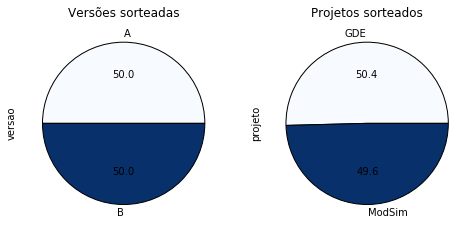

In [20]:
print('\nDISTRIBUIÇÃO DAS VERSÕES E PROJETOS ALEATÓRIOS\n')

plt.subplot(221)
plt.title('Versões sorteadas')
data.versao.value_counts().plot(kind='pie', colormap='Blues', autopct='%.1f', figsize=(8,8))

plt.subplot(222)
plt.title('Projetos sorteados')
data.projeto.value_counts().plot(kind='pie', colormap='Blues', autopct='%.1f', figsize=(8,8))

plt.show()

<p>Os gráficos acima nos mostram que usando a função aleatória no script do site, conseguimos uma distribuição muito bem equilibrada, com exatamente 50% em cada versão, e muito próximo da metade nos projetos.</p>

In [55]:
#Filtragem de dados - Vimos que alguém deixou um tempo absurdo aberto
vA = data[(data.versao == "A") & (data.delta_t < 3000)]
vB = data[(data.versao == "B") & (data.delta_t < 3000)]

#VERSÃO A - cálculo de média e variância
mu_Ta = vA.delta_t.mean()
s_Ta = vA.delta_t.var()

mu_cata = vA.delta_t_cat.mean()
s_cata = vA.delta_t_cat.var()

mu_fa = vA.delta_t_final.mean()
s_fa = vA.delta_t_final.var()

print("""
VERSÃO A

Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_Ta, s_Ta, mu_cata, s_cata, mu_fa, s_fa))
print("Tamanho da Amostra em A: ", vA.shape[0])

#VERSÃO B - cálculo de média e variância
mu_Tb = vB.delta_t.mean()
s_Tb = vB.delta_t.var()

mu_catb = vB.delta_t_cat.mean()
s_catb = vB.delta_t_cat.var()

mu_fb = vB.delta_t_final.mean()
s_fb = vB.delta_t_final.var()

print("""
\n\nVERSÃO B

Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_Tb, s_Tb, mu_catb, s_catb, mu_fb, s_fb))
print("Tamanho da Amostra em B: ", vB.shape[0])


VERSÃO A

Média (Delta T): 32.960807400818005
Variância (Delta T): 149.61659426471314

Média (Delta T Categoria-Inicial): 42.58056576278127
Variância (Delta T Categoria-Inicial): 1648.8615740616628

Média (Delta T Final-Categoria): 32.89142102249468
Variância (Delta T Final-Categoria): 149.58426522633332
Tamanho da Amostra em A:  489



VERSÃO B

Média (Delta T): 32.44058332515355
Variância (Delta T): 155.6587316029042

Média (Delta T Categoria-Inicial): 32.43760126584877
Variância (Delta T Categoria-Inicial): 155.7480551375136

Média (Delta T Final-Categoria): 32.435237224948715
Variância (Delta T Final-Categoria): 154.98791351025216
Tamanho da Amostra em B:  489


<h4>O que as medidas de tendência central e dispersão nos mostram?</h4>
<p>A partir da análise dos valores, vimos que realmente a média é muito próxima entre as diferentes versões, mas, há de se notar o desvio padrão das amostras.<p>

<h3>PARTE 3 | Inferências estatísticas</h3>
<p>Para amostras com um número de elementos superior a 30, é plausível usarmos o TLC (Teorema do Limite Central) como inferência estatística. Desse modo, serão levantadas duas curvas normais, uma da versão A e outra da B, de modo a encontrar qual delas seria a melhor versão.</p>
<p>Procedimento de análise:</p>
<ol>
<li>Levantamento das curvas normais das versões A e B</li>
<li>Construção da região crítica e intervalo de confiança</li>
<li>Check I (pré-conclusão) das análises feitas</li>
<li>Levantamento das curvas por projeto em cada versão</li>
<li>Construção da região crítica e intervalo de confiança</li>
<li>Check II das análises feitas</li>
<li>Conclusão</li>
</ol>
<h3>As Hipóteses</h3>
<p><strong>Hipótese Nula- H0:</strong> Média de tempo de B < média de tempo de A</p>
<p><strong>Hipótese Alternativa - Ha:</strong> Média de tempo de B >= média de tempo A</p>
<h3>3.1 | Curvas Normais</h3>

VERSÃO A


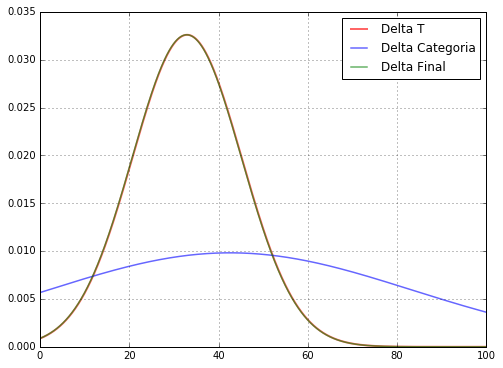

VERSÃO B


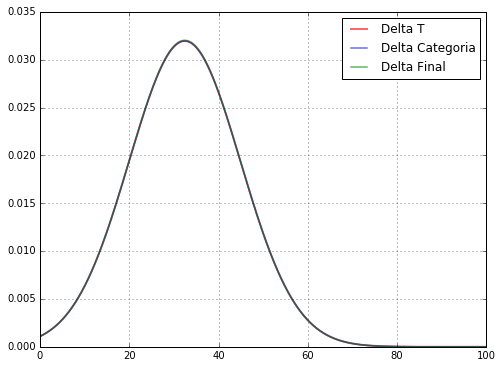

In [101]:
x = np.linspace(0, 100, 10000)
y_T = stats.norm.pdf(x, loc=mu_Ta, scale=math.sqrt(s_Ta))
y_cat = stats.norm.pdf(x, loc=mu_cata, scale=math.sqrt(s_cata))
y_f = stats.norm.pdf(x, loc=mu_fa, scale=math.sqrt(s_fa))

print("VERSÃO A")

plt.figure(figsize=(8, 6))
plt.plot(x, y_T, lw=2, alpha=0.6, label="Delta T", color="r")
plt.plot(x, y_cat, lw=1.5, alpha=0.6, label="Delta Categoria", color="b")
plt.plot(x, y_f, lw=1.5, alpha=0.6, label="Delta Final", color="g")
plt.legend(loc='best')
plt.grid()

plt.show()
#________________________________________________________________________________________________________________________________

x = np.linspace(0, 100, 10000)
y_T = stats.norm.pdf(x, loc=mu_Tb, scale=math.sqrt(s_Tb))
y_cat = stats.norm.pdf(x, loc=mu_catb, scale=math.sqrt(s_catb))
y_f = stats.norm.pdf(x, loc=mu_fb, scale=math.sqrt(s_fb))

print("VERSÃO B")

plt.figure(figsize=(8, 6))
plt.plot(x, y_T, lw=2, alpha=0.6, label="Delta T", color="r")
plt.plot(x, y_cat, lw=1.5, alpha=0.6, label="Delta Categoria", color="b")
plt.plot(x, y_f, lw=1.5, alpha=0.6, label="Delta Final", color="g")
plt.legend(loc='best')
plt.grid()

plt.show()

<h4>Primeiras observações</h4>
<p>Percebe-se que as curvas normais do tempo total de ambas as versões está muito próximo, ou seja, existe uma possibilidade de que o tempo médio seja muito próximo.</p>
<p>Pode-se observar, também, que na versão A, há uma grande variância entre os tempos para se achar as categorias, ou seja, <strong>será que apesar de ambas as versões terem um tempo médio próximo, na versão B é mais fácil achar a categoria?</strong></p>
<h3>3.2 | Intervalo de Confiança</h3>

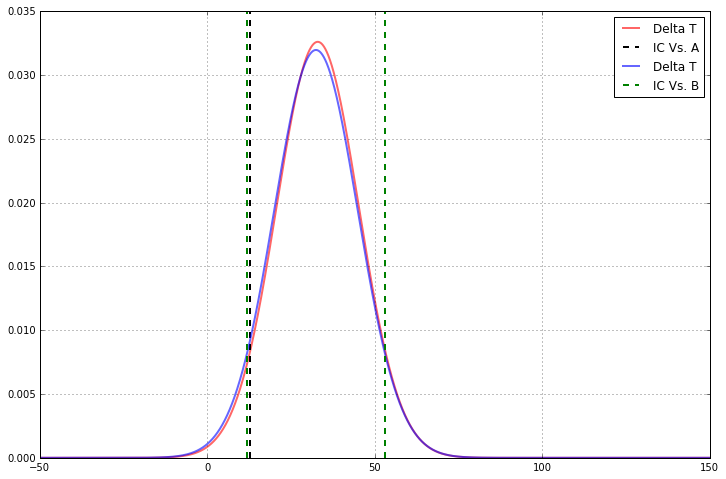


Média A: 32.961
Média B: 32.441

Intervalo de Confiança (95%) A: (12.841309463818089, 53.080305337817919) - tamanho: 40.238995873999826
Intervalo de Confiança (95%) B: (11.918851859192099, 52.962314791114991) - tamanho: 41.04346293192289


In [124]:
#Para apenas o DELTA_T

z95 = stats.norm.ppf(.95, loc=0, scale=1) #gamma de 95%

#A
y_T = stats.norm.pdf(x, loc=mu_Ta, scale=math.sqrt(s_Ta))
IC = ((mu_Ta-z95*math.sqrt(s_Ta), (mu_Ta+z95*math.sqrt(s_Ta))))

#B
y_Tb = stats.norm.pdf(x, loc=mu_Tb, scale=math.sqrt(s_Tb))
ICb = ((mu_Tb-z95*math.sqrt(s_Tb), (mu_Tb+z95*math.sqrt(s_Tb))))

#Start Plot
plt.figure(figsize=(12, 8))
#Plot A
plt.plot(x, y_T, lw=2, alpha=0.6, label="Delta T", color="r")
plt.axvline(IC[0], lw=2, ls="dashed", color='black', label="IC Vs. A")
plt.axvline(IC[1], lw=2, ls="dashed", color='black')
#Plot B
plt.plot(x, y_Tb, lw=2, alpha=0.6, label="Delta T", color="b")
plt.axvline(ICb[0], lw=2, ls="dashed", color='g', label="IC Vs. B")
plt.axvline(ICb[1], lw=2, ls="dashed", color='g')

plt.legend(loc='best')
plt.grid()

plt.show()

print("""
Média A: {0}
Média B: {1}

Intervalo de Confiança (95%) A: {2} - tamanho: {4}
Intervalo de Confiança (95%) B: {3} - tamanho: {5}""".format(round(mu_Ta, 3), round(mu_Tb, 3), IC, ICb, (IC[1]-IC[0]),
                                                             (ICb[1]-ICb[0])))


<h3>3.3 | Check I</h3>
<p>Primeiramente foram definidas as hipóteses nula e alternativa, e com base nelas seguimos o processo de inferência estatística.</p>
<p>Logo no item 3.1 foi possível se observar que talvez a B fosse melhor que a versão A, mas não necessariamente no tempo médio total de se achar um projeto, mas, na dificuldade ou facilidade de se encontrar a categoria em que o projeto estava "escondido".</p>
<p>Pelo item 3.2, podemos observar que as médias do tempo total são extremamentes próximas e, os intervalos para um coeficiente de confiança de 95% também, ou seja, <strong>rejeitamos a Hipótese Nula</strong> de que a média de tempo da versão B é maior que a A. Desse modo, devemos refazer nossa inferência.</p>
<p>Se conseguimos provar que o tempo médio e o intervalo de confiança de ambas as versões são muito próximos, podemos então testar novas hipóteses.</p>
<p>Vale ressaltar que o "tamanho" expresso no gráfico acima, se refere a distância que o intervalo de confiança preenche</p>
<h4>Novas Hipóteses</h4>
<p><strong>Hipótese Nula- H0:</strong> Média de tempo para achar a categoria do projeto em B < média de tempo para achar a categoria do projeto em A</p>
<p><strong>Hipótese Alternativa - Ha:</strong>  Média de tempo para achar a categoria do projeto em B >= média de tempo para achar a categoria do projeto em A</p>

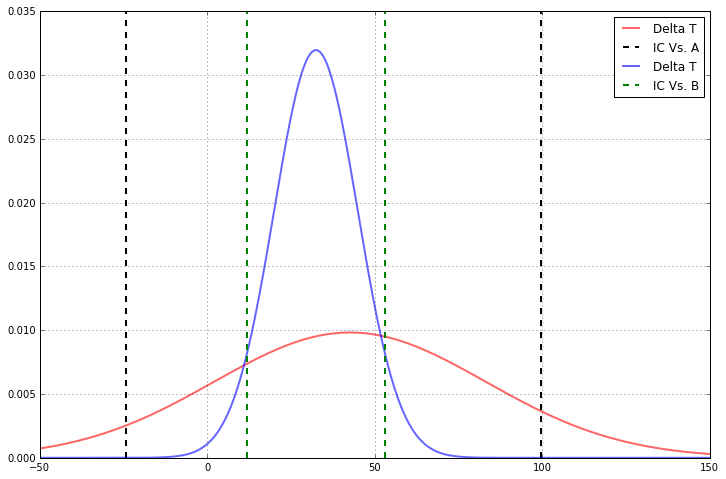


Média A: 42.581
Média B: 32.438

Intervalo de Confiança (95%) A: (-24.210651013169077, 99.752024176768344) - tamanho: 123.96267518993741
Intervalo de Confiança (95%) B: (11.909982527539366, 52.968202063462954) - tamanho: 41.058219535923584


In [125]:
#Para apenas o DELTA_T ATÉ ENCONTRAR A CATEGORIA
x = np.linspace(-50, 150, 10000)
z95 = stats.norm.ppf(.95, loc=0, scale=1) #gamma de 95%

#A
y_T = stats.norm.pdf(x, loc=mu_cata, scale=math.sqrt(s_cata))
IC = ((mu_cata-z95*math.sqrt(s_cata), (mu_Ta+z95*math.sqrt(s_cata))))

#B
y_Tb = stats.norm.pdf(x, loc=mu_catb, scale=math.sqrt(s_catb))
ICb = ((mu_catb-z95*math.sqrt(s_catb), (mu_Tb+z95*math.sqrt(s_catb))))

#Start Plot
plt.figure(figsize=(12, 8))
#Plot A
plt.plot(x, y_T, lw=2, alpha=0.6, label="Delta T", color="r")
plt.axvline(IC[0], lw=2, ls="dashed", color='black', label="IC Vs. A")
plt.axvline(IC[1], lw=2, ls="dashed", color='black')
#Plot B
plt.plot(x, y_Tb, lw=2, alpha=0.6, label="Delta T", color="b")
plt.axvline(ICb[0], lw=2, ls="dashed", color='g', label="IC Vs. B")
plt.axvline(ICb[1], lw=2, ls="dashed", color='g')

plt.legend(loc='best')
plt.grid()

plt.show()

print("""
Média A: {0}
Média B: {1}

Intervalo de Confiança (95%) A: {2} - tamanho: {4}
Intervalo de Confiança (95%) B: {3} - tamanho: {5}""".format(round(mu_cata, 3), round(mu_catb, 3), IC, ICb, (IC[1]-IC[0]),
                                                             (ICb[1]-ICb[0])))



<h3>3.3.2 | Check I - Continuação</h3>
<p>Analisando a distribuição acima e os valores das medidas mostrados, é possível observar que a média de tempo para se encontrar uma categoria de projeto na versão B é menor que em A, e ainda, observa-se que o intervalo de confiança (coeficiente de confiança de 95%) de A é muito maior que B, ou seja, <strong>não rejeitamos a hipótese nula H0</strong>, já que é possível observar que achar uma categoria de projeto em B é mais rápido que achar em A.</p>
<p><strong>Até o momento:</strong> A versão B é melhor que a A pois os usuários acham com maior facilidade as categorias</p>

In [68]:
### ModSim
mod_A = vA[vA.projeto == "ModSim"]
mod_B = vB[vB.projeto == "ModSim"]

#### plt.subplot(221)
plt.title('Versões sorteadas para ModSim')
data.versao[data.projeto == "ModSim"].value_counts().plot(kind='pie', colormap='PuBu_r', autopct='%.1f', figsize=(8,8))

In [69]:
#ModSim versão A
mu_mod_A = mod_A.delta_t.mean()
s_mod_A = mod_A.delta_t.var()

mu_cat_Mod_A = mod_A.delta_t_cat.mean()
s_cat_Mod_A = mod_A.delta_t_cat.var()

mu_fb_Mod_A = mod_A.delta_t_final.mean()
s_fb_Mod_A = mod_A.delta_t_final.var()

print("ModSim versão A")
print("""Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_mod_A, s_mod_A, mu_cat_Mod_A, s_cat_Mod_A, mu_fb_Mod_A, s_fb_Mod_A))

ModSim versão A
Média (Delta T): 32.77845833195022
Variância (Delta T): 156.23281032279908

Média (Delta T Categoria-Inicial): 40.213620970954445
Variância (Delta T Categoria-Inicial): 1336.6072669328385

Média (Delta T Final-Categoria): 32.71048685892104
Variância (Delta T Final-Categoria): 156.10770685549963


In [70]:
#ModSim versão B
mu_mod_B = mod_B.delta_t.mean()
s_mod_B = mod_B.delta_t.var()

mu_cat_Mod_B = mod_B.delta_t_cat.mean()
s_cat_Mod_B = mod_B.delta_t_cat.var()

mu_fb_Mod_B = mod_B.delta_t_final.mean()
s_fb_Mod_B = mod_B.delta_t_final.var()

print("ModSim versão B")

print("""Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_mod_B, s_mod_B, mu_cat_Mod_B, s_cat_Mod_B, mu_fb_Mod_B, s_fb_Mod_B))

ModSim versão B
Média (Delta T): 31.896569815573866
Variância (Delta T): 170.7886054309538

Média (Delta T Categoria-Inicial): 31.893642098360733
Variância (Delta T Categoria-Inicial): 170.8731312803912

Média (Delta T Final-Categoria): 31.888980459016313
Variância (Delta T Final-Categoria): 170.27062127434186


In [71]:
#GDE
gde_A = vA[vA.projeto == "GDE"]
gde_B = vB[vB.projeto == "GDE"]

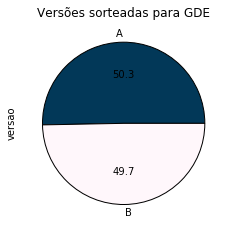

In [72]:
plt.subplot(221)
plt.title('Versões sorteadas para GDE')
data.versao[data.projeto == "GDE"].value_counts().plot(kind='pie', colormap='PuBu_r', autopct='%.1f', figsize=(8,8))

In [73]:
#GDE versão A
mu_gde_A = gde_A.delta_t.mean()
s_gde_A = gde_A.delta_t.var()

mu_cat_gde_A = gde_A.delta_t_cat.mean()
s_cat_gde_A = gde_A.delta_t_cat.var()

mu_fb_gde_A = gde_A.delta_t_final.mean()
s_fb_gde_A = gde_A.delta_t_final.var()

print("GDE versão A")
print("""Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_gde_A, s_gde_A, mu_cat_gde_A, s_cat_gde_A, mu_fb_gde_A, s_fb_gde_A))

GDE versão A
Média (Delta T): 33.13800952016132
Variância (Delta T): 143.72964632402292

Média (Delta T Categoria-Inicial): 44.88070162903245
Variância (Delta T Categoria-Inicial): 1948.1637409488067

Média (Delta T Final-Categoria): 33.06724817338698
Variância (Delta T Final-Categoria): 143.78832048751002


In [74]:
#GDE versão B
mu_gde_B = gde_B.delta_t.mean()
s_gde_B = gde_B.delta_t.var()

mu_cat_gde_B = gde_B.delta_t_cat.mean()
s_cat_gde_B = gde_B.delta_t_cat.var()

mu_fb_gde_B = gde_B.delta_t_final.mean()
s_fb_gde_B = gde_B.delta_t_final.var()

print("GDE versão B")
print("""Média (Delta T): {0}
Variância (Delta T): {1}

Média (Delta T Categoria-Inicial): {2}
Variância (Delta T Categoria-Inicial): {3}

Média (Delta T Final-Categoria): {4}
Variância (Delta T Final-Categoria): {5}""".format(mu_gde_B, s_gde_B, mu_cat_gde_B, s_cat_gde_B, mu_fb_gde_B, s_fb_gde_B))

GDE versão B
Média (Delta T): 32.98237637142867
Variância (Delta T): 140.63811764062902

Média (Delta T Categoria-Inicial): 32.97934019183682
Variância (Delta T Categoria-Inicial): 140.73270328192265

Média (Delta T Final-Categoria): 32.979264371428485
Variância (Delta T Final-Categoria): 139.80746119728548


### Hipótese 0: mu_A = mu_B

### Hipótese A: mu_A != mu_B

### Alfa = 3%

In [75]:
#ModSim 
n_mod = len(mod_B)
porcent_mod = stats.t.cdf(x = mu_mod_B, df = (n_mod-1), loc = mu_mod_A, scale = s_mod_B)
porcent_mod

0.49794213860834047

###### Rejeito Hipótese Nula

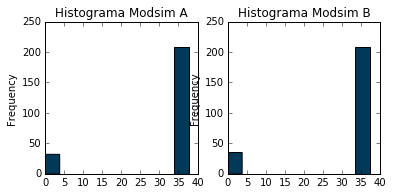

In [76]:
plt.subplot(221)
plt.title('Histograma Modsim A')
mod_A.delta_t.plot(kind='hist', colormap='PuBu_r', figsize=(6,6))

plt.subplot(222)
plt.title('Histograma Modsim B')
mod_B.delta_t.plot(kind='hist', colormap='PuBu_r', figsize=(6,6))

plt.show()

In [77]:
#GDE
n_gde = len(gde_B)
porcent_gde = stats.t.cdf(x = mu_gde_B, df = (n_gde-1), loc = mu_gde_A, scale = s_gde_B)
porcent_gde

0.49955897413209055

###### Rejeito Hipótese Nula

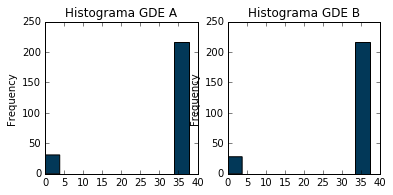

In [78]:
plt.subplot(221)
plt.title('Histograma GDE A')
gde_A.delta_t.plot(kind='hist', colormap='PuBu_r', figsize=(6,6))

plt.subplot(222)
plt.title('Histograma GDE B')
gde_B.delta_t.plot(kind='hist', colormap='PuBu_r', figsize=(6,6))

plt.show()